# ML Assignment
## Course: Machine Learning 2023-2024 (054061)
## Student(s): Lorenzo Zoccatelli (10664683)

In [1]:
# Import libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load training set:
training_parameters = pd.read_csv('training_parameters.csv')
N = len(training_parameters)

Let's start by plotting all the simulation results:

Simulation 0


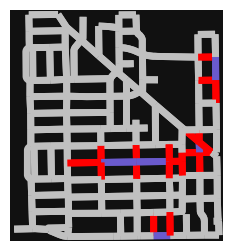

In [3]:
import osmnx as ox

def visualize(G, df):
    ec = []
    flooded_init_edges = set([tuple(x) for x in df[df['flooded_init']][['head_id', 'tail_id']].to_numpy()])
    flooded_final_edges = set([tuple(x) for x in df[df['flooded_final']][['head_id', 'tail_id']].to_numpy()])

    for u, v, k in G.edges(keys=True):
        if (u, v) in flooded_init_edges or (v, u) in flooded_init_edges:
            ec.append('slateblue')
        elif (u, v) in flooded_final_edges or (v, u) in flooded_final_edges:
            ec.append('red')
        else:
            ec.append('silver')

    fig, ax = ox.plot_graph(G, edge_color=ec, node_size=0, edge_linewidth=5, figsize=(3,3), close=False)

G = ox.graph_from_bbox(29.79, 29.80, -95.377, -95.387, network_type='drive')

for i in range(1):  #range(N)
    df = pd.read_csv('./training/'+str(i)+'.csv')
    print("Simulation "+str(i))
    visualize(G, df)

In [4]:
# How many dummy variables are needed for 'SurfaceType?'
print(set(training_parameters['SurfaceType']))

{'D', 'B', 'C', 'A'}


So we need x3 dummy features to represent the variable 'SurfaceType'.

Let's build a new training dataset in the following format:   
  
X: | flo_init1 | flo_init2 | ... | flo_init191 | SurfaceType_A | SurfaceType_B | SurfaceType_C | RainfallIntensity | init_max_hour | DrainageSystemCapacity | GreenSpaceRatio |  
for a total of 198 features, where the flo_inits variables (binary) are set to 0 or 1 to signal if that street (191 in total) is flooded or not at the beginning, and the other variables describe the general settings of the city.  
  
Y: | flo_final1 | flo_final2 | ... | flo_final191  
for a total of 191 values (binary) to predict, they would have indicated wheter or not a street (191 in total) was predicted to be flooded  
  
This idea was then abandoned for different reasons (that we will see more in details later in the notebook):  
1) ALL the streets that start the simulation flooded, stay flooded, therefore it is useless to ask our model to predict their final status (we can immediately set their predicted value to '1')
2) obviously, edges are more than nodes. Therefore, instead of using as features the initial flooding status of the street, we can use the initial flooding status of the nodes, and instead of predicting the final status of the streets, we can predict the final status of the nodes. In this way we reduce both the number of features and the number of fields to predict. An inconvenient is how to decide wheter or not a node is flooded. To create our new training data, we decided to consider a node as 'flooded' if there is at least one street connected to it that is flooded. And, in our predictions, we decided to consider a street as predicted flooded if both its start and end node are predicted to be flooded. Of course, also admitting that we can manage to find a model that predicts the flooding condition of each node with a 100% accuracy, it means that we will consider some streets as flooded because its head and tail nodes are flooded, while in reality it is not (e.g. in the example provided below, street 2-3 will be predicted as 'flooded' because node 2 and 3 are predicted as 'flooded' by our model). Still, only a minority of streets are in this condition and will be mistakenly classified as flooded while they are not (anyway, it is better to have a false negative than a false positive), so we accept this approximation.
3) if instead of a multi-output model (the format above) we train a single-output model (there is one row in our training set for every street in every simulation, and the only target value to predict is the final status of that street), we can oversample the minority class (predicted flooded streets).

In [5]:
# Check how many nodes we have and get their ids:
my_nodes = pd.read_csv('edge_info.csv')
heads = list(my_nodes['head_id'])
tails = list(my_nodes['tail_id'])
my_nodes = list(set(heads + tails))
print("Total nodes:", len(my_nodes))
print(my_nodes)

Total nodes: 127
[152909828, 152909832, 152909837, 5387962359, 152692258, 153194019, 152541735, 152541736, 152541738, 152692266, 152541741, 153444946, 153456725, 153444951, 153341528, 153456737, 152707200, 153222786, 152426116, 152426120, 152628888, 152628890, 152331933, 152331936, 152600226, 152600229, 152600233, 152721578, 152600236, 152721580, 152600240, 152600247, 152541371, 152751816, 152130254, 152130257, 152130265, 152130268, 152943327, 152677092, 153233124, 152677095, 152130280, 152677096, 152341226, 153099498, 152677099, 152341229, 153233134, 153099505, 152223474, 152223479, 153233144, 153233147, 153233148, 152432894, 153233151, 152432898, 152432902, 152432904, 152432906, 152432908, 152432914, 152432917, 152432928, 152559392, 6259947808, 2889941805, 152656696, 152656703, 152437059, 151779659, 153204564, 152432996, 152432997, 152659814, 152432999, 152433002, 1191806314, 153204588, 153465195, 152433006, 152659843, 152659845, 152659849, 152659851, 152659853, 153312143, 152659857,

So our training set will look like this:
  
X: | [node1_id] | [node2_id] | ... | [node126_id] | flooded_[node1_id] | flooded_[node2_id] | ... | flooded_[node127_id] | SurfaceType_A | SurfaceType_B | SurfaceType_C | RainfallIntensity | init_max_hour | DrainageSystemCapacity | GreenSpaceRatio |  
for a total of 260 features. The first 126 features are needed to "select" which node we are currently trying to predict (all fields equal to 0 except for the field corresponding to the id of the node we want to predict), in other words they are 126 dummy variables (126 features required to codify 127 possible nodes). While the following 127+7 features are just a description of our simulated world.  
  
Y: | target |  
The only value to predict correspond to the future situation of the street selected.

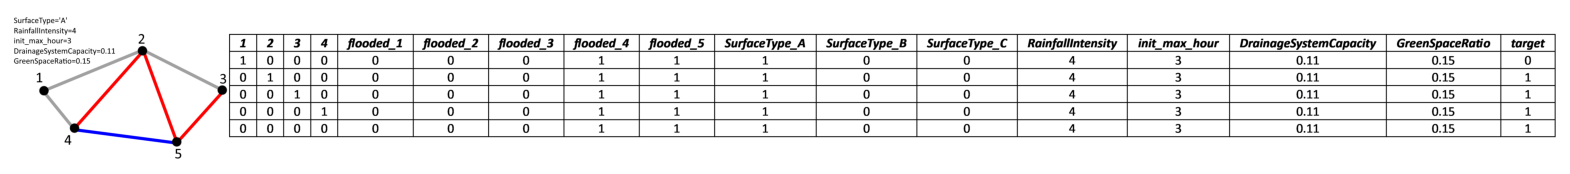

In [6]:
# An example to illustrate the format of our training set:
%matplotlib inline
import imageio as iio
image = iio.v3.imread('dataset_format.png')
plt.figure(figsize=(20, 5))
plt.axis(False)
plt.imshow(image)

In [7]:
# Create columns'name of the new dataframe:
nodes_dummy = []
nodes_status = []
for i in my_nodes:
    nodes_dummy.append(str(i))
    nodes_status.append("flooded_"+str(i))
nodes_dummy = nodes_dummy[:-1]
column_names = nodes_dummy + nodes_status + ["SurfaceType_A", "SurfaceType_B", "SurfaceType_C", "RainfallIntensity", "init_max_hour", "DrainageSystemCapacity", "GreenSpaceRatio", "target"]
print(column_names)

['152909828', '152909832', '152909837', '5387962359', '152692258', '153194019', '152541735', '152541736', '152541738', '152692266', '152541741', '153444946', '153456725', '153444951', '153341528', '153456737', '152707200', '153222786', '152426116', '152426120', '152628888', '152628890', '152331933', '152331936', '152600226', '152600229', '152600233', '152721578', '152600236', '152721580', '152600240', '152600247', '152541371', '152751816', '152130254', '152130257', '152130265', '152130268', '152943327', '152677092', '153233124', '152677095', '152130280', '152677096', '152341226', '153099498', '152677099', '152341229', '153233134', '153099505', '152223474', '152223479', '153233144', '153233147', '153233148', '152432894', '153233151', '152432898', '152432902', '152432904', '152432906', '152432908', '152432914', '152432917', '152432928', '152559392', '6259947808', '2889941805', '152656696', '152656703', '152437059', '151779659', '153204564', '152432996', '152432997', '152659814', '1524329

In [8]:
dataset = np.zeros((N*127, 126+127+7+1))

for i in range(N):

    # Set last 7 features (same for all 127 node observations from the same simulation):
    if training_parameters.loc[i, "SurfaceType"] == 'A':
        dataset[i*127:(i+1)*127,126+127] = 1
    elif training_parameters.loc[i, "SurfaceType"] == 'B':
        dataset[i*127:(i+1)*127,126+127+1] = 1
    elif training_parameters.loc[i, "SurfaceType"] == 'C':
        dataset[i*127:(i+1)*127,126+127+2] = 1 
    dataset[i*127:(i+1)*127,126+127+3] = training_parameters.loc[i, "RainfallIntensity"]
    dataset[i*127:(i+1)*127,126+127+4] = training_parameters.loc[i, "init_max_hour"]
    dataset[i*127:(i+1)*127,126+127+5] = training_parameters.loc[i, "DrainageSystemCapacity"]
    dataset[i*127:(i+1)*127,126+127+6] = training_parameters.loc[i, "GreenSpaceRatio"]

    df = pd.read_csv('training/'+str(i)+'.csv')
    n = len(df)
    for j in  range(n):

        # Set a '1' in one of the first 127 features for every row
        if j < 126:
            dataset[i*127+j,j] = 1

        # Set the value of the features from the 126th to the 126+127-1th to describe the initial situations of the nodes (same for all 127 node observations from the same simulation):
        if df.loc[j,'flooded_init'] == 1:
            dataset[i*127:(i+1)*127,126+my_nodes.index(df.loc[j,'head_id'])] = 1
            dataset[i*127:(i+1)*127,126+my_nodes.index(df.loc[j,'tail_id'])] = 1

        # Set the target value to predict:  
        if df.loc[j,'flooded_final'] == 1:
            dataset[i*127+my_nodes.index(df.loc[j,'head_id']),126+127+7] = 1
            dataset[i*127+my_nodes.index(df.loc[j,'tail_id']),126+127+7] = 1

my_training_data = pd.DataFrame(dataset, columns=column_names)
my_training_data.head()
#my_training_data.tail()

,152909828,152909832,152909837,5387962359,152692258,153194019,152541735,152541736,152541738,152692266,...,flooded_153143291,flooded_152909821,SurfaceType_A,SurfaceType_B,SurfaceType_C,RainfallIntensity,init_max_hour,DrainageSystemCapacity,GreenSpaceRatio,target
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.11,0.11,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.11,0.11,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.11,0.11,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.11,0.11,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.11,0.11,0.0


### Now our dataset is ready!
Quick remark: someone could think to insert also the characteristics of streets and corners ('longitude', 'latitude', 'altitude', adiacent streets,...) as variables to feed our model, but this would be wrong. As a matter of fact, all observations are taken from the same simulation (same city layout), therefore it is useless to consider the disposition of the streets as variables. Our model will autonomously find correlations among features: there is no need that we say to it that street 1 and street 2 are adiacent and therefore -probably- correlated. And our model will understand autonomously if a street is more likely to ended up flooded compared to another one, with no need that we say that it has lower altitude.  
  
Let's give a look to correlation and other characteristics of the variable to see if there is anything we can do to imporve or clean it

In [9]:
# Let's give a look to the correlation among features:
# Of course, ignore the first 127 dummy varibles and study only the rest (taken only once)

to_corr = my_training_data.iloc[::127, 126:]

corr = to_corr.corr()
corr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

Of course, some nodes are more correlated among them than with others, but still, we don't notice any strong correlation that could lead us to drop some features.

In [10]:
# Check if one of the nodes results always flooded or always dry:
for i in range(127):
    if len(list(set(my_training_data.iloc[i::127, 126+127+7]))) == 1:
        print(str(i)+"th node has only "+str(list(set(my_training_data.iloc[i::127, 127+127+7]))))

No, there are no nodes that are always flooded or always dry (in this case we could have avoided to predict these nodes and just placed the value they always assume)

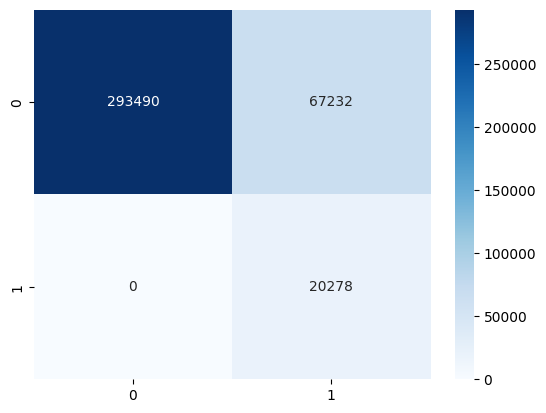

In [11]:
# Check relationship between intial and final status of each node:

N = len(my_training_data)
initial_status = np.zeros((N))
final_status = my_training_data['target']
toRemove = []

for i in range(N):
    initial_status[i] = my_training_data.iloc[i,126+i%127]
    if initial_status[i] and final_status[i]:
        toRemove.append(i)

from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(initial_status, final_status), annot=True, fmt='d', cmap="Blues");

We notice that, if a node is flooded at the beginning of the flooding, it stays flooded until the end of the flooding.  
Therefore, we can avoid to predict what happens for the streets already flooded and we can immediately predict them to be flooded.  
So let's delete the 20.278 rows about predicting the final status of an already flooded street.

In [12]:
my_training_data.drop(toRemove, axis=0, inplace=True)
print("Data removed: "+str(N-len(my_training_data)))

Data removed: 20278


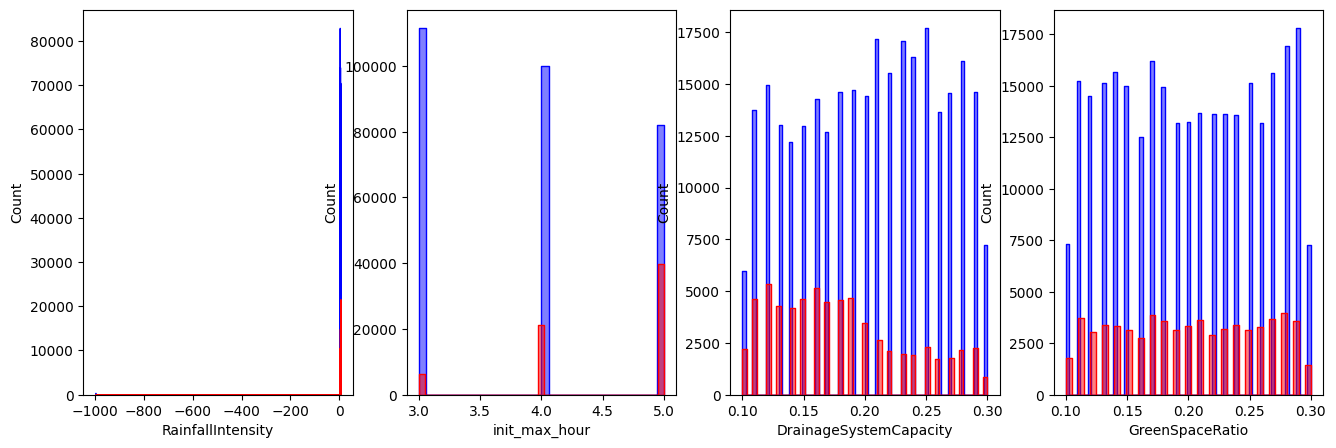

In [13]:
# Let's give a look to the non-binary variables to see how they influence the target:

X0 = my_training_data[my_training_data['target']==0]
X1 = my_training_data[my_training_data['target']==1]

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(16,5))
sns.histplot(X0.loc[:,'RainfallIntensity'], color="blue", element="step", ax=ax[0], alpha=0.5)
sns.histplot(X1.loc[:,'RainfallIntensity'], color="red", element="step", ax=ax[0], alpha=0.5)
sns.histplot(X0.loc[:,'init_max_hour'], color="blue", element="step", ax=ax[1], alpha=0.5)
sns.histplot(X1.loc[:,'init_max_hour'], color="red", element="step", ax=ax[1], alpha=0.5)
sns.histplot(X0.loc[:,'DrainageSystemCapacity'], color="blue", element="step", ax=ax[2], alpha=0.5)
sns.histplot(X1.loc[:,'DrainageSystemCapacity'], color="red", element="step", ax=ax[2], alpha=0.5)
sns.histplot(X0.loc[:,'GreenSpaceRatio'], color="blue", element="step", ax=ax[3], alpha=0.5)
sns.histplot(X1.loc[:,'GreenSpaceRatio'], color="red", element="step", ax=ax[3], alpha=0.5)
plt.show()

In [14]:
# To avoid to lose data, we can substitute the inconsistent value '-999' with an approximation: the median value of RainfallIntensity
my_training_data.loc[my_training_data.index[my_training_data['RainfallIntensity']<0], :]

,152909828,152909832,152909837,5387962359,152692258,153194019,152541735,152541736,152541738,152692266,...,flooded_153143291,flooded_152909821,SurfaceType_A,SurfaceType_B,SurfaceType_C,RainfallIntensity,init_max_hour,DrainageSystemCapacity,GreenSpaceRatio,target
10033,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-999.0,3.0,0.11,0.27,0.0
10034,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-999.0,3.0,0.11,0.27,0.0
10035,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-999.0,3.0,0.11,0.27,0.0
10036,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-999.0,3.0,0.11,0.27,1.0
10037,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-999.0,3.0,0.11,0.27,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-999.0,4.0,0.18,0.11,0.0
220848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-999.0,4.0,0.18,0.11,0.0
220849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-999.0,4.0,0.18,0.11,0.0
220851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-999.0,4.0,0.18,0.11,1.0


In [15]:
my_training_data.loc[my_training_data['RainfallIntensity'] < 0, 'RainfallIntensity'] = 3.5

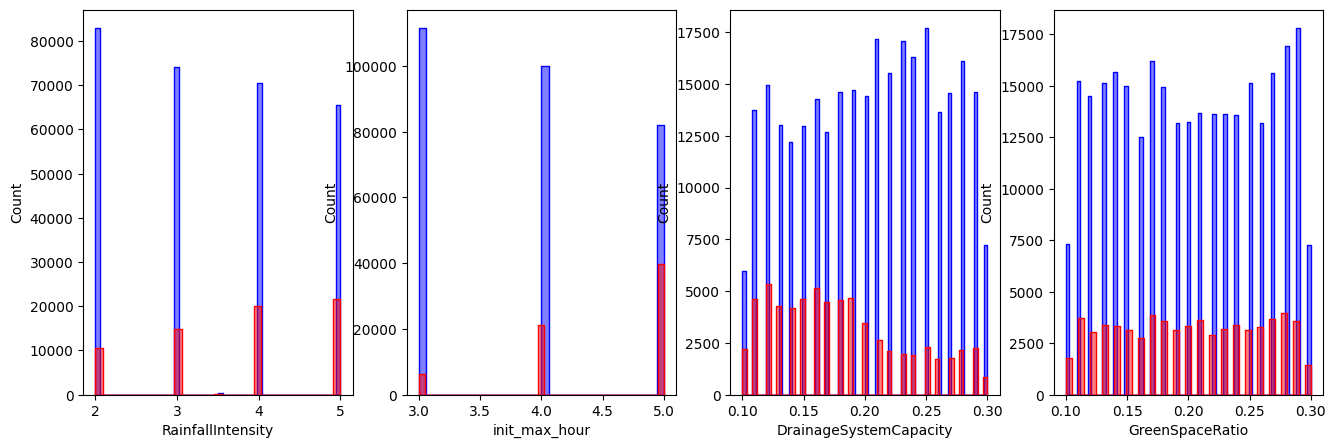

In [16]:
# Let's give once again a look to the non-binary variables to see how they influence the target:

X0 = my_training_data[my_training_data['target']==0]
X1 = my_training_data[my_training_data['target']==1]

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(16,5))
sns.histplot(X0.loc[:,'RainfallIntensity'], color="blue", element="step", ax=ax[0], alpha=0.5)
sns.histplot(X1.loc[:,'RainfallIntensity'], color="red", element="step", ax=ax[0], alpha=0.5)
sns.histplot(X0.loc[:,'init_max_hour'], color="blue", element="step", ax=ax[1], alpha=0.5)
sns.histplot(X1.loc[:,'init_max_hour'], color="red", element="step", ax=ax[1], alpha=0.5)
sns.histplot(X0.loc[:,'DrainageSystemCapacity'], color="blue", element="step", ax=ax[2], alpha=0.5)
sns.histplot(X1.loc[:,'DrainageSystemCapacity'], color="red", element="step", ax=ax[2], alpha=0.5)
sns.histplot(X0.loc[:,'GreenSpaceRatio'], color="blue", element="step", ax=ax[3], alpha=0.5)
sns.histplot(X1.loc[:,'GreenSpaceRatio'], color="red", element="step", ax=ax[3], alpha=0.5)
plt.show()

Now our data are clean and ready: time to split the dataset in train and test set

Data for training: 288577
Data for testing: 72145


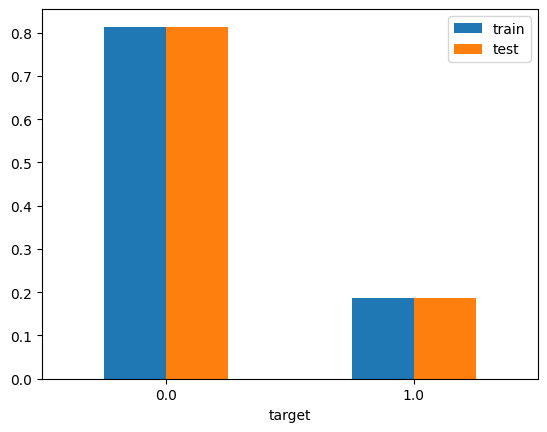

In [17]:
# Split data:
from sklearn.model_selection import train_test_split

X = my_training_data.drop(['target'], axis=1)
y = my_training_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

y_train_dist = y_train.groupby(y_train.iloc[:]).size()/y_train.size
y_test_dist = y_test.groupby(y_test.iloc[:]).size()/y_test.size
train_test_dist = pd.DataFrame({'train': y_train_dist, 'test': y_test_dist})
ax = train_test_dist.plot.bar(rot=0)

print("Data for training:", len(X_train))
print("Data for testing:", len(X_test))

### Oversampling the minority class
Oversampling the observations with 'target'=1 means giving more importance, more weight, to these observations.  
We do so not only to balance the training set (and therefore to avoid that our model will overpredict the 0 class), but also because it is better to face the risk of overpredicting a flooded street rather than bear the risk of not predicting a flood: better to have a false positive than a false negative (it is better to send a rescue team in a safe zone that doesn't require any help rather than not sending a rescue team in a flooded street)

In [18]:
from sklearn.utils import resample

# Separate majority and minority classes:
X_train_majority = X_train[y_train==0]
X_train_minority = X_train[y_train==1]
y_train_majority = y_train[y_train==0]
y_train_minority = y_train[y_train==1]

# Oversample minority class:
X_train_min_up, y_train_min_up = resample(X_train_minority, y_train_minority, replace=True, n_samples=X_train_majority.shape[0], random_state=123)

# Combine oversampled minority class with majority class:
X_train_up = pd.concat([X_train_min_up, X_train_majority])
y_train_up = pd.concat([y_train_min_up, y_train_majority])

# Print results:
y_train_up.value_counts()

target
1.0    234875
0.0    234875
Name: count, dtype: int64

### Scaling data
In some ML models scaling is not required to get good results but still, because we are not sure which approach we will follow, we scale them. Of course, the majority of features are binary, so we scale all the other variables between 0 and 1.

In [19]:
# Scale data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((0,1)).fit(X_train_up)

scaled_data = scaler.transform(X_train_up.astype(float))
scaled_X_train = pd.DataFrame(scaled_data.astype(float))
scaled_X_train.columns = X_train_up.columns

scaled_data = scaler.transform(X_test.astype(float))
scaled_X_test = pd.DataFrame(scaled_data.astype(float))
scaled_X_test.columns = X_test.columns

### Should we apply PCA?
We could be tempted to apply PCA because we have a lot of features, some nodes seem quite highly correlated with others and because 100 PCs are enough to explain 85% of variability of our data.  
But, because the first 126th variable are all needed to codify which node we want to predict, if we delete one of them we are forgetting information on which nodes we are trying to predict, so it can be risky to approximate our dataset through PCA.
Still, we compute the PCs just to be ready to reduce the dataset in case 260 variables are too many for our models

In [20]:
# PCA fit
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(scaled_X_train)
pca_X_train = pd.DataFrame(pca.transform(scaled_X_train))
pca_X_test = pd.DataFrame(pca.transform(scaled_X_test))
pca_X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,0.770474,-0.095710,-0.098043,-0.542989,0.524944,-0.621486,1.055874,-0.172595,-0.381791,0.477338,...,0.004417,-0.117984,0.021485,0.151315,0.191933,-0.007715,0.003826,0.021902,0.018138,-0.000574
1,0.868591,-0.031107,-0.127488,-0.318513,-0.310883,0.579282,-0.380872,-0.299221,-0.274450,0.242080,...,-0.001241,0.032188,-0.025532,0.112250,-0.060344,0.144763,-0.035415,-0.039352,-0.012262,-0.000998
2,0.000707,0.117899,0.195863,-0.743768,0.446147,-0.298174,0.689105,-0.071907,-0.270398,-0.073926,...,0.001833,0.170529,0.022825,0.119353,-0.049198,0.015117,0.004874,-0.014435,-0.014325,-0.000302
3,0.813672,0.143443,0.478614,-0.491553,-0.107058,0.584723,-0.052269,-0.088014,-0.068257,0.110945,...,0.002384,0.034869,0.030998,0.019210,-0.031079,-0.043914,-0.115116,-0.023119,0.015550,0.000108
4,-0.278498,0.613703,-0.751676,-0.253141,-0.008558,0.155538,-0.411786,-0.039959,-0.364236,-0.206927,...,-0.001236,-0.075230,-0.070546,-0.103858,0.041080,0.017999,-0.127274,0.020821,-0.018984,-0.000290


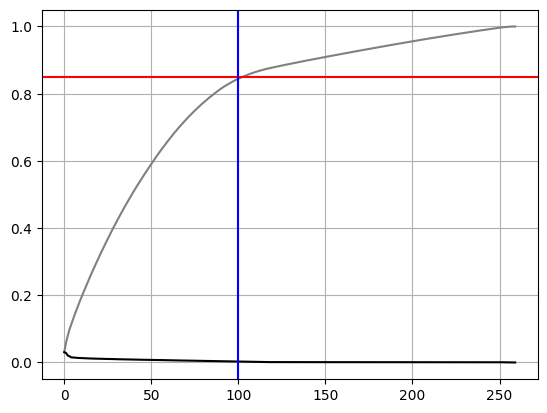

In [22]:
explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(pca_X_train.columns, cum_explained_var, color='grey')
plt.plot(pca_X_train.columns, explained_var, color='black')
plt.axhline(0.85, color='red')
plt.axvline(100, color='blue')
plt.grid()
plt.show()

### Knearest?
No: this model is incapable of finding meaningful relations among features.  
E.g. suppose that we have only two sample observations, each one about a different node, taken from the same simulation (so all features except for the first 126 dummies are the same). One of these two nodes will be flooded, while the other will stay dry. Now, let's suppose we want to predict the final status of a node adjacent to the dry node. We would expect that this node is likely to stay dry too, like its neighbor. But according to knearest algorithm, both training nodes have the same distance from the node to predict, so the outcome predicted will be 0.5.

### Decision Tree
Let's try with a Decision Tree Classifier. It is one of the less computationally expensive model.

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 'max_depth': [3,5,7], 'min_samples_split': [100,200], 'min_samples_leaf': [100,200]}
gs = GridSearchCV(classifier, parameters, cv=2, scoring='f1', verbose=True, n_jobs=-1)
gs = gs.fit(pca_X_train, y_train_up)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


KeyboardInterrupt: 

In [ ]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.705014 using {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 100, 'min_samples_split': 100}
0.695377 (0.000610) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 100, 'min_samples_split': 100}
0.695377 (0.000610) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 100, 'min_samples_split': 200}
0.695377 (0.000610) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 200, 'min_samples_split': 100}
0.695377 (0.000610) with: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 200, 'min_samples_split': 200}
0.688033 (0.002614) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 100}
0.688033 (0.002614) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 200}
0.688033 (0.002614) with: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 200, 'min_samples_split': 100}
0.688033 (0.002614) with: {'crite

***RESULTS ON TEST SET***
F1_score: 45.76 %
Accuracy: 67.87 %
Recall: 72.17 %


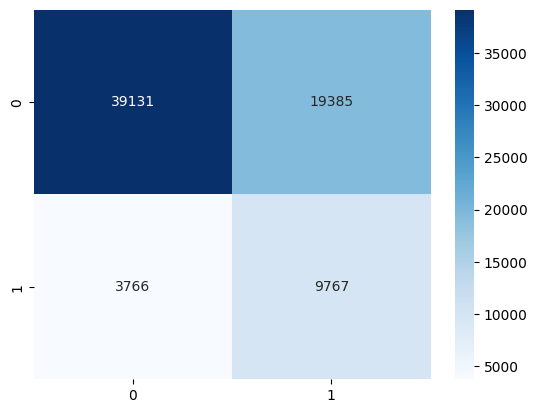

In [ ]:
y_pred = gs.best_estimator_.predict(pca_X_test)

from sklearn import metrics
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues");

print('***RESULTS ON TEST SET***')
print("F1_score:", round(metrics.f1_score(y_test, y_pred)*100,2), "%")
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred)*100,2), "%")
print("Recall:", round(metrics.recall_score(y_test, y_pred)*100,2), "%")

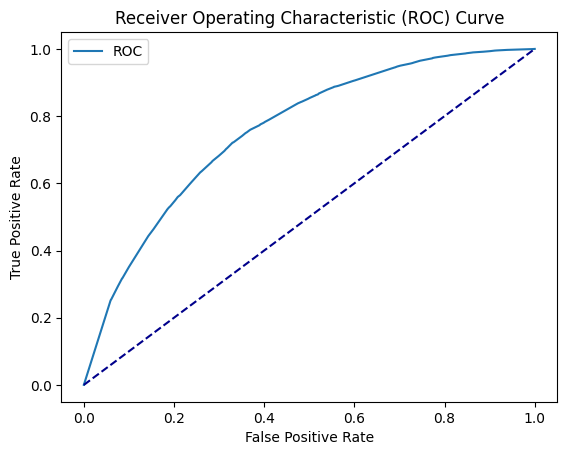

AUC: 0.76


In [ ]:
y_probs = gs.best_estimator_.predict_proba(pca_X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

This model could be acceptable: it has a high Recall, so it means we will have relatively few unexpected flooded streets. But because of the high false positives, it means we are going to waste a lot of resources (a lot of rescue teams dispatched) to patrol safe streets.

### Neural Network
Let's try a Neural Network model. In the GridSearch we set less parameters to test (or else it would take too long to train it).  
We try all the three possible activation function (except for 'identity': we want to try a model more complex than just a linear one) and we try a single hidden layout with 127 nodes (as many as the nodes to predict) and two hidden layout with 50 and 25 nodes each. We notice that in the first case the model has to fit (126+127+7)x127+127x1=33147 weights, while in the second case there are (126+127+7)x50+50x25+25=14275 parameters. In both cases the number of parameters to estimate are way lower than the samples available (234595x2), so the risk of overfitting is very low.

In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

classifier = MLPClassifier()
parameters = {"activation": ['logistic','tanh','relu'], "hidden_layer_sizes":[(127),(50,25)], "max_iter": [100000], "alpha": [0.1]}

gs = GridSearchCV(classifier, parameters, cv=2, scoring = 'recall', verbose=True, n_jobs=-1, refit=True)
# we are particularly interested in the recall measurment: our priority is to minimize the false negative (district predicted to be safe but in reality being flooded)
gs = gs.fit(pca_X_train, y_train_up)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


In [24]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.969303 using {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 127, 'max_iter': 100000}
0.709492 (0.027371) with: {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 127, 'max_iter': 100000}
0.787572 (0.000144) with: {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (50, 25), 'max_iter': 100000}
0.868900 (0.016222) with: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 127, 'max_iter': 100000}
0.960975 (0.000068) with: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (50, 25), 'max_iter': 100000}
0.969303 (0.002171) with: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 127, 'max_iter': 100000}
0.961409 (0.009128) with: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (50, 25), 'max_iter': 100000}


***RESULTS ON TEST SET***
F1_score: 79.34 %
Accuracy: 90.89 %
Recall: 93.26 %


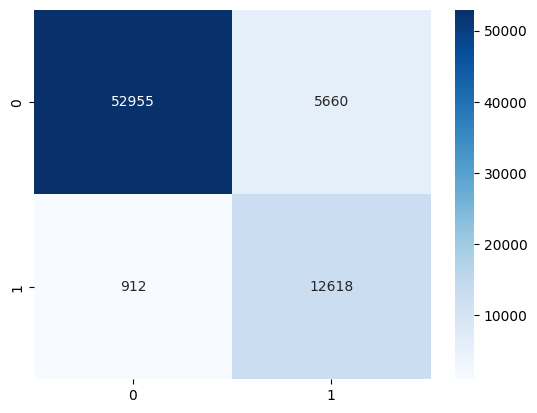

In [25]:
y_pred = gs.best_estimator_.predict(pca_X_test)

from sklearn import metrics
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues");

print('***RESULTS ON TEST SET***')
print("F1_score:", round(metrics.f1_score(y_test, y_pred)*100,2), "%")
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred)*100,2), "%")
print("Recall:", round(metrics.recall_score(y_test, y_pred)*100,2), "%")

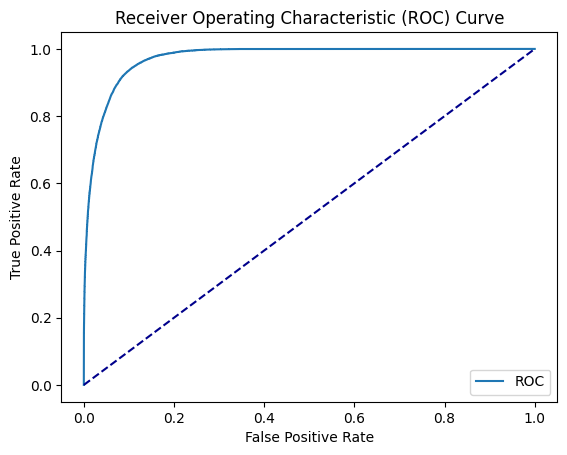

AUC: 0.97


In [26]:
y_probs = gs.best_estimator_.predict_proba(pca_X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)

This model is acceptable: it performs well, so there is no need to explore further models.

In [ ]:
# Save last model:
import pickle

with open('10664683.pkl', 'wb') as file:
    pickle.dump(gs.best_estimator_, file)

## Prediction:
Let's now apply our model to new simulations

In [ ]:
# Load prediction set:
prediction_parameters = pd.read_csv('test_parameters.csv')
N = len(prediction_parameters)

# Load pre-trained model:
with open('10664683.pkl', 'rb') as file:
    loaded_classifier = pickle.load(file)

for i in range(N):
    df = pd.read_csv('test/'+str(i)+'.csv')
    dataset = np.zeros((127, 126+127+7))

    # For each observation, the last 127+7 features are about the charateristics and status of the map before the flooding
    if training_parameters.loc[i, "SurfaceType"] == 'A':
        dataset[:,126+127] = 1
    elif training_parameters.loc[i, "SurfaceType"] == 'B':
        dataset[:,126+127+1] = 1
    elif training_parameters.loc[i, "SurfaceType"] == 'C':
        dataset[:,126+127+2] = 1

    if training_parameters.loc[i, "RainfallIntensity"]<0:
        dataset[:,126+127+3] = 3.5 # medium value of RainfallIntensity
    else:
        dataset[:,126+127+3] = training_parameters.loc[i, "RainfallIntensity"]
    if training_parameters.loc[i, "init_max_hour"]<0:
        dataset[:,126+127+4] = 4 # medium value of init_max_hour
    else:
        dataset[:,126+127+4] = training_parameters.loc[i, "init_max_hour"]
    if training_parameters.loc[i, "DrainageSystemCapacity"]<0:
        dataset[:,126+127+5] = 0.2 # medium value of DrainageSystemCapacity
    else:
        dataset[:,126+127+5] = training_parameters.loc[i, "DrainageSystemCapacity"]
    if training_parameters.loc[i, "GreenSpaceRatio"]<0:
        dataset[:,126+127+6] = 0.2 # medium value of GreenSpaceRatio
    else:
        dataset[:,126+127+6] = training_parameters.loc[i, "GreenSpaceRatio"]

    df = pd.read_csv('test/'+str(i)+'.csv')
    n = len(df)
    for j in range(n):
        if j < 126:
            dataset[j,j] = 1
        if df.loc[j,'flooded_init'] == 1:
            dataset[:,126+my_nodes.index(df.loc[j,'head_id'])] = 1
            dataset[:,126+my_nodes.index(df.loc[j,'tail_id'])] = 1

    to_predict = pd.DataFrame(dataset, columns=column_names[:-1])
    


    # Scale data:
    scaled_data = scaler.transform(to_predict.astype(float))
    scaled_X_train = pd.DataFrame(scaled_data.astype(float))
    scaled_X_train.columns = to_predict.columns

    # Apply PCA:
    pca_X_train = pd.DataFrame(pca.transform(scaled_X_train))

    # Predict:
    y_pred = loaded_classifier.predict(pca_X_train)

    # Save results:
    df['flooded_final'] = df['flooded_init']
    for j in range(127):
        if y_pred[my_nodes.index(df.loc[j,'head_id'])] == 1 and y_pred[my_nodes.index(df.loc[j,'tail_id'])] == 1 :
            df.loc[j,'flooded_final'] = True

    # Write results:
    df.to_csv("test/"+str(i)+".csv", index=False)

Through another file (seeSim.ipynb), I compared the results of the training simulations and the predicted results we have obtained.  
In general, in the training simulations, the flooded streets are all around the streets flooded at the beginning of the simulation.  
Looking at the results obtained, we notice a consistent behaviour, so we have another evidence of the validity of our model.